In [1]:
library(splatter)
library(Seurat)
library(dplyr)
library(scater)
library(mclust)
library(plyr)

data("sc_example_counts")

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, rank, rbind,
    rowMeans, rowSums, r

In [2]:
seurat_preprocess <- function(data, scale=TRUE){
    # Create seurat object
    obj <- CreateSeuratObject(raw.data = data, min.cells = 3, min.genes = 200)
    
    # Filter out cells based on percentage of mitochondrial genes
    mito.genes <- grep(pattern = "^MT-", x = rownames(x = obj@data), value = TRUE)
    percent.mito <- Matrix::colSums(obj@raw.data[mito.genes, ])/Matrix::colSums(obj@raw.data)
    obj <- AddMetaData(object = obj, metadata = percent.mito, col.name = "percent.mito")
    
    # Normalize data
    obj <- NormalizeData(object = obj, normalization.method = "LogNormalize", 
        scale.factor = 10000)
    
    # Filter out only variable genes
    obj <- FindVariableGenes(object = obj, mean.function = ExpMean, dispersion.function = LogVMR, 
        x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5, do.plot = FALSE)
    
    # Regress out unwanted sources of variation
    if (scale){
        obj <- ScaleData(object = obj, vars.to.regress = c("nUMI", "percent.mito"))
    }
    
    return(obj)
}

seurat_pipeline <- function(data, resolution=0.6){
    
    obj <- seurat_preprocess(data)
    
    # PCA
    obj <- RunPCA(object = obj, pc.genes = obj@var.genes, do.print = FALSE)
    obj <- ProjectPCA(object = obj, do.print = FALSE)
    
    # Run clustering using computed PCs
    obj <- FindClusters(object = obj, reduction.type = "pca", dims.use = 1:10, 
        resolution = resolution, print.output = 0, save.SNN = TRUE)
    
    return(obj)
}

Regressing out: nUMI, percent.mito



Time Elapsed:  26.914630651474 secs

Scaling data matrix


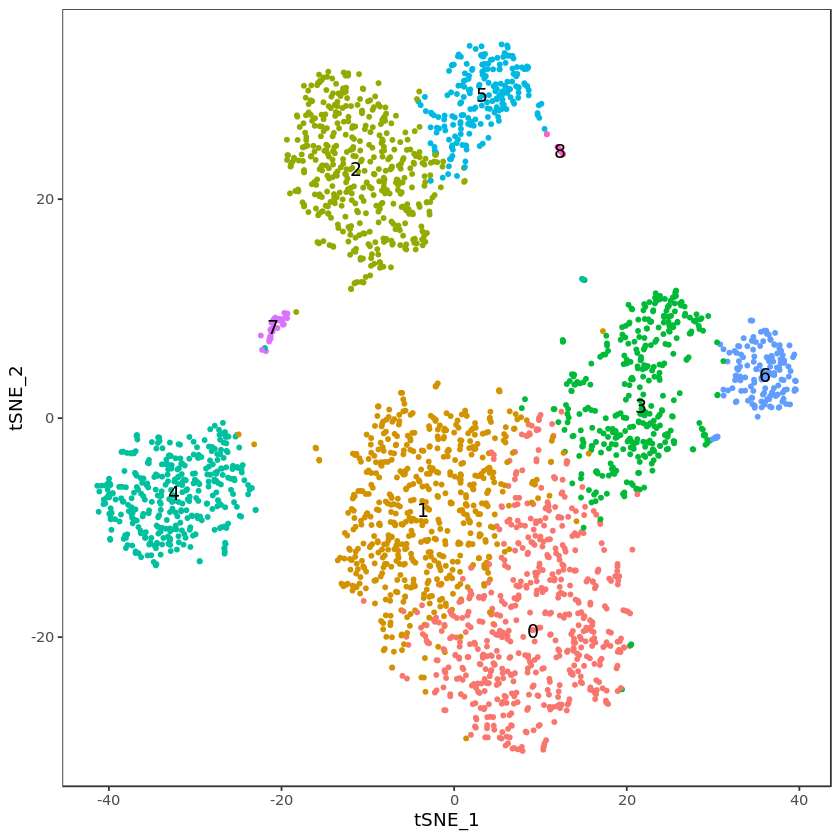

In [3]:
pbmc.data <- Read10X(data.dir = "../filtered_gene_bc_matrices/hg19/")
pbmc <- seurat_pipeline(pbmc.data, resolution = 0.8)
pbmc <- RunTSNE(object = pbmc, dims.use = 1:10, do.fast = TRUE)
plot <- TSNEPlot(object = pbmc, do.return = TRUE, no.legend = TRUE, do.label = TRUE)
plot_grid(plot)

M = as.data.frame(as.matrix(pbmc@data))
write.table(M, file = sprintf('pbmc_seurat_preprocessed.txt'))
write.table(pbmc@ident, file = sprintf('pbmc_seurat_labels.txt'))
write.table(pbmc@dr$tsne@cell.embeddings, file = sprintf('pbmc_seurat_tsne.txt'))

In [4]:
seurat_pipeline <- function(data, resolution=0.6){
    
    obj <- seurat_preprocess(data)
    
    # PCA
    obj <- RunPCA(object = obj, pc.genes = obj@var.genes, do.print = FALSE)
    obj <- ProjectPCA(object = obj, do.print = FALSE)
    
    # Run clustering using computed PCs
    obj <- FindClusters(object = obj, reduction.type = "pca", dims.use = 1:10, 
        resolution = resolution, print.output = 0, save.SNN = TRUE)
    
    return(obj)
}

In [5]:
compare_clusters <- function(pbmc, ident0, ident1){

    # Grab clusters 0 and 1
    c0cells <- WhichCells(object = pbmc, ident = ident0, random.seed = 1)
    c0cells1 <- sample(c0cells, size=floor(length(c0cells)/2))
    c1cells <- WhichCells(object = pbmc, ident = ident1, random.seed = 1)
    c1cells1 <- sample(c1cells, size=floor(length(c1cells)/2))
    cells1 <- c(c0cells1, c1cells1)
    ctest.data = pbmc@raw.data[, cells1, drop = F]

    ctest <- seurat_pipeline(ctest.data)
    write.table(c(c0cells1, c1cells1), file = sprintf('pbmc_seurat_%sv%s_cellsamp1.txt', ident0, ident1))
    write.table(ctest@ident, file = sprintf('pbmc_seurat_%sv%s_cellsamplabels1.txt', ident0, ident1))
    orig_labels <- droplevels(pbmc@ident[c(c0cells1, c1cells1)])
    table(ctest@ident, orig_labels)

    # Test Seurat's differential expression methods
    tests <- c("t",
               "wilcox",
               "bimod",
               "tobit",
               "poisson",
               "negbinom",
               "MAST")

    for (test in tests){
        print(test)
        de <- FindMarkers(ctest,
                          ident.1 = 0,
                          ident.2 = 1,
                          test.use = test)
        write.table(de, file = sprintf('pbmc_seurat_%sv%s_de_%s.txt', ident0, ident1, test))
        print(head(de))
    }
}

In [6]:
compare_clusters(pbmc, 0, 1)

Regressing out: nUMI, percent.mito



Time Elapsed:  12.7597005367279 secs

Scaling data matrix


[1] "t"
                p_val  avg_logFC pct.1 pct.2    p_val_adj
S100A4   4.233237e-44 -1.0676683 0.688 0.956 4.355577e-40
B2M      4.352756e-25 -0.3105814 1.000 1.000 4.478551e-21
IL32     4.031377e-24 -0.6912321 0.730 0.948 4.147884e-20
CLIC1    6.125698e-17 -0.6046579 0.293 0.635 6.302731e-13
LGALS1   2.090378e-16 -1.1334360 0.135 0.417 2.150790e-12
SH3BGRL3 7.519743e-16 -0.5940358 0.737 0.900 7.737063e-12
[1] "wilcox"
                p_val  avg_logFC pct.1 pct.2    p_val_adj
S100A4   1.461607e-41 -1.0676683 0.688 0.956 1.503847e-37
B2M      8.529444e-30 -0.3105814 1.000 1.000 8.775945e-26
IL32     7.801961e-23 -0.6912321 0.730 0.948 8.027438e-19
SH3BGRL3 6.865693e-18 -0.5940358 0.737 0.900 7.064112e-14
HLA-A    3.834722e-17 -0.3898838 0.987 0.989 3.945545e-13
CLIC1    1.043895e-16 -0.6046579 0.293 0.635 1.074064e-12
[1] "bimod"
                p_val  avg_logFC pct.1 pct.2    p_val_adj
S100A4   2.636126e-45 -1.0676683 0.688 0.956 2.712310e-41
B2M      3.290187e-23 -0.3105814 1.000 

Warning message in FUN(X[[i]], ...):
"Skipping gene --- FUT7. Fewer than3 in at least one of the two clusters."

               p_val  avg_logFC pct.1 pct.2     p_val_adj
B2M    9.622079e-136 -0.3105814 1.000 1.000 9.900157e-132
S100A4 9.880344e-117 -1.0676683 0.688 0.956 1.016589e-112
LTB     8.058213e-66 -0.5305505 0.901 0.970  8.291096e-62
IL32    3.049093e-53 -0.6912321 0.730 0.948  3.137212e-49
RPS3A   8.587628e-39  0.2592982 0.997 1.000  8.835810e-35
HLA-A   5.217230e-38 -0.3898838 0.987 0.989  5.368008e-34
[1] "negbinom"


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w

               p_val  avg_logFC pct.1 pct.2    p_val_adj
S100A4  6.055882e-43 -1.0676683 0.688 0.956 6.230897e-39
IL32    3.127142e-21 -0.6912321 0.730 0.948 3.217517e-17
LGALS1  1.027571e-17 -1.1334360 0.135 0.417 1.057268e-13
B2M     1.316580e-17 -0.3105814 1.000 1.000 1.354629e-13
HLA-A   4.139177e-17 -0.3898838 0.987 0.989 4.258799e-13
S100A11 1.030593e-15 -0.7636097 0.286 0.561 1.060377e-11
[1] "MAST"


Assuming data assay in position 1, with name et is log-transformed.
                                                                              
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
                                                                              
Done!


                p_val  avg_logFC pct.1 pct.2    p_val_adj
S100A4   7.828765e-46 -1.0676683 0.688 0.956 8.055016e-42
B2M      2.147411e-23 -0.3105814 1.000 1.000 2.209471e-19
IL32     3.031312e-23 -0.6912321 0.730 0.948 3.118917e-19
LGALS1   5.382884e-17 -1.1334360 0.135 0.417 5.538449e-13
SH3BGRL3 1.330774e-16 -0.5940358 0.737 0.900 1.369233e-12
HLA-A    1.859968e-16 -0.3898838 0.987 0.989 1.913722e-12


In [7]:
compare_clusters(pbmc, 1, 3)

Regressing out: nUMI, percent.mito



Time Elapsed:  12.3948571681976 secs

Scaling data matrix


[1] "t"
             p_val  avg_logFC pct.1 pct.2    p_val_adj
NKG7  1.453720e-75 -2.7946943 0.192 0.959 1.418976e-71
CCL5  7.101607e-74 -1.7761659 0.249 0.946 6.931878e-70
CST7  7.144644e-44 -1.9014548 0.101 0.803 6.973887e-40
GZMA  3.581200e-42 -1.7514360 0.136 0.810 3.495609e-38
CTSW  2.129086e-36 -1.4381779 0.363 0.871 2.078201e-32
HLA-C 2.954899e-33 -0.7533696 0.981 0.993 2.884277e-29
[1] "wilcox"
             p_val  avg_logFC pct.1 pct.2    p_val_adj
NKG7  1.975148e-66 -2.7946943 0.192 0.959 1.927942e-62
CST7  8.393214e-55 -1.9014548 0.101 0.803 8.192616e-51
CCL5  7.394643e-51 -1.7761659 0.249 0.946 7.217911e-47
GZMA  1.867412e-48 -1.7514360 0.136 0.810 1.822781e-44
HLA-C 1.803806e-38 -0.7533696 0.981 0.993 1.760695e-34
CTSW  7.161183e-37 -1.4381779 0.363 0.871 6.990031e-33
[1] "bimod"
             p_val  avg_logFC pct.1 pct.2    p_val_adj
NKG7  1.386483e-77 -2.7946943 0.192 0.959 1.353346e-73
CCL5  3.076473e-61 -1.7761659 0.249 0.946 3.002945e-57
CST7  1.704893e-54 -1.9014548 0.

Warning message in FUN(X[[i]], ...):
"Skipping gene --- CD160. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- XCL1. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- C1orf21. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- FHIT. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- KLRD1. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- ACTN1. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- GPR56. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- LINC00176. Fewer than3 in at least one of the two clusters."

              p_val  avg_logFC pct.1 pct.2     p_val_adj
NKG7  2.723983e-291 -2.7946943 0.192 0.959 2.658880e-287
CCL5  4.089310e-269 -1.7761659 0.249 0.946 3.991575e-265
B2M   1.612726e-141 -0.4488257 1.000 1.000 1.574182e-137
RPL13 1.137332e-140  0.3589484 1.000 1.000 1.110150e-136
RPS12 1.459372e-127  0.4661912 1.000 1.000 1.424493e-123
RPL32 1.575522e-122  0.4568983 1.000 1.000 1.537867e-118
[1] "negbinom"


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in FUN(X[[i]], ...):
"Skipping gene --- CD160. Fewer than 3 in at least one of the two clusters."Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, l

"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message

"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in FUN(X[[i]], ...):
"Skipping gene --- GPR56. Fewer than 3 in at least one of the two clusters."Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in the

              p_val  avg_logFC pct.1 pct.2     p_val_adj
NKG7  4.259886e-108 -2.7946943 0.192 0.959 4.158075e-104
GZMA   4.785430e-53 -1.7514360 0.136 0.810  4.671058e-49
CST7   1.677534e-49 -1.9014548 0.101 0.803  1.637441e-45
CTSW   1.793435e-38 -1.4381779 0.363 0.871  1.750571e-34
RPS27  8.212854e-32  0.3980825 1.000 0.993  8.016567e-28
HLA-C  2.929120e-31 -0.7533696 0.981 0.993  2.859114e-27
[1] "MAST"


Assuming data assay in position 1, with name et is log-transformed.
                                                                              
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
                                                                              
Done!


             p_val  avg_logFC pct.1 pct.2    p_val_adj
NKG7  4.039270e-78 -2.7946943 0.192 0.959 3.942731e-74
CCL5  2.443167e-58 -1.7761659 0.249 0.946 2.384775e-54
CST7  1.938925e-55 -1.9014548 0.101 0.803 1.892585e-51
GZMA  8.792281e-49 -1.7514360 0.136 0.810 8.582145e-45
HLA-C 5.965016e-41 -0.7533696 0.981 0.993 5.822452e-37
CTSW  2.446377e-38 -1.4381779 0.363 0.871 2.387909e-34


In [8]:
compare_clusters(pbmc, 2, 5)

Regressing out: nUMI, percent.mito



Time Elapsed:  10.9235987663269 secs

Scaling data matrix


[1] "t"
              p_val  avg_logFC pct.1 pct.2    p_val_adj
LYZ    6.192311e-25  1.0900711 1.000 0.981 5.609614e-21
FCGR3A 7.964873e-23 -2.0131956 0.182 0.722 7.215378e-19
S100A9 4.144008e-20  1.1281181 0.995 0.898 3.754057e-16
IFITM2 2.502748e-19 -1.1910058 0.645 0.898 2.267239e-15
GPX1   1.290303e-18  0.8551064 0.953 0.630 1.168885e-14
S100A8 2.967683e-16  0.8004918 0.967 0.630 2.688424e-12
[1] "wilcox"
              p_val  avg_logFC pct.1 pct.2    p_val_adj
LYZ    3.073546e-27  1.0900711 1.000 0.981 2.784326e-23
FCGR3A 4.585765e-27 -2.0131956 0.182 0.722 4.154244e-23
IFITM2 4.523266e-21 -1.1910058 0.645 0.898 4.097627e-17
S100A9 8.603717e-21  1.1281181 0.995 0.898 7.794107e-17
GPX1   1.351208e-19  0.8551064 0.953 0.630 1.224059e-15
RPS19  7.153656e-19 -0.5812126 0.991 0.991 6.480497e-15
[1] "bimod"
              p_val  avg_logFC pct.1 pct.2    p_val_adj
LYZ    8.519336e-48  1.0900711 1.000 0.981 7.717666e-44
FCGR3A 1.601513e-30 -2.0131956 0.182 0.722 1.450811e-26
IFITM2 1.519308

Warning message in FUN(X[[i]], ...):
"Skipping gene --- NLRP3. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- MGST2. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- NRG1. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- RNASE2. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- LTB4R. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- ITGAM. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- VMO1. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- CCL3L3. Fewer than3 in at least one of the two clusters."Warning message in FUN(X[[i]], ...):
"Skipping gene --- C19orf59. Fewer than3 in at least one of the two

               p_val  avg_logFC pct.1 pct.2     p_val_adj
S100A9  0.000000e+00  1.1281181 0.995 0.898  0.000000e+00
LYZ     0.000000e+00  1.0900711 1.000 0.981  0.000000e+00
S100A8 2.209023e-161  0.8004918 0.967 0.630 2.001154e-157
RPS19  3.150016e-160 -0.5812126 0.991 0.991 2.853599e-156
TMSB4X 1.796955e-156 -0.2541289 1.000 1.000 1.627862e-152
FTH1   3.290532e-150 -0.2843240 1.000 1.000 2.980892e-146
[1] "negbinom"


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in FUN(X[[i]], ...):
"Skipping gene --- NLRP3. Fewer than 3 in at least one of the two clusters."Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, l

"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message

              p_val  avg_logFC pct.1 pct.2    p_val_adj
LYZ    1.837923e-55  1.0900711 1.000 0.981 1.664974e-51
S100A9 7.348006e-40  1.1281181 0.995 0.898 6.656558e-36
FCGR3A 5.581211e-30 -2.0131956 0.182 0.722 5.056019e-26
GPX1   8.743288e-23  0.8551064 0.953 0.630 7.920545e-19
S100A8 1.353535e-22  0.8004918 0.967 0.630 1.226167e-18
IFITM2 5.007335e-20 -1.1910058 0.645 0.898 4.536145e-16
[1] "MAST"


Assuming data assay in position 1, with name et is log-transformed.
                                                                              
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
                                                                              
Done!


              p_val  avg_logFC pct.1 pct.2    p_val_adj
LYZ    2.270334e-39  1.0900711 1.000 0.981 2.056696e-35
FCGR3A 9.610261e-31 -2.0131956 0.182 0.722 8.705935e-27
IFITM2 1.836701e-25 -1.1910058 0.645 0.898 1.663868e-21
S100A9 1.352173e-24  1.1281181 0.995 0.898 1.224933e-20
GPX1   8.633099e-22  0.8551064 0.953 0.630 7.820724e-18
S100A8 6.689356e-20  0.8004918 0.967 0.630 6.059887e-16
